# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ovm.monetary.model import MonetaryModel

import logging
import os
import random
import typing as tp

import line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
# %matplotlib widget
from mesa.datacollection import DataCollector
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
import numpy as np
import pandas as pd
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from tqdm import tqdm

from ovm.monetary.agents import (
    MonetaryAgent, 
    MonetaryArbitrageur, 
    MonetaryKeeper, 
    MonetaryLiquidator, 
    MonetarySniper
)

from ovm.monetary.markets import MonetaryFMarket
from ovm.monetary.model import MonetaryModel
from ovm.monetary.data_collection import DataCollectionOptions
from ovm.monetary.plot_labels import (
    price_deviation_label,
    spot_price_label,
    futures_price_label,
    skew_label,
    inventory_wealth_ovl_label,
    inventory_wealth_usd_label,
    GINI_LABEL,
    GINI_ARBITRAGEURS_LABEL,
    SUPPLY_LABEL,
    TREASURY_LABEL,
    LIQUIDITY_LABEL, 
)

from ovm.monetary.plots import (
    DEFAULT_FIGURE_SIZE, 
    convert_time_in_seconds_to_index, 
    convert_time_interval_in_seconds_to_indices, 
    construct_full_time_axis, 
    construct_time_axis, 
    get_indices_and_time_axis_to_plot, 
    plot_multiple_variables_over_time, 
    plot_price_deviations, 
    plot_skews, 
    plot_single_variable_over_time, 
    plot_single_variable_over_time_from_numpy_array, 
    plot_supply, 
    plot_treasury, 
    plot_liquidity, 
    plot_spot_vs_futures_price, 
    plot_open_positions
)

from ovm.monetary.reporters import * 
from ovm.monetary.data_io import (
    construct_sims_map, 
    construct_ticker_to_series_of_prices_map_from_simulated_prices, 
    construct_ticker_to_series_of_prices_map_from_historical_prices, 
    load_and_construct_ticker_to_series_of_prices_map_from_historical_prices,
    construct_abs_data_input_with_historical_data, 
    construct_hist_map
)

from ovm.paths import (
    HistoricalDataSource, 
    construct_historical_data_directory
)

from ovm.simulation.bootstrap import plot_multivariate_simulation
from ovm.simulation.resampling import (
    load_log_returns,
    simulate_new_price_series_via_bootstrap,
    store_simulated_price_series_in_output_directory
)

from ovm.tickers import (
    ETH_USD_TICKER,
    COMP_USD_TICKER,
    LINK_USD_TICKER,
    YFI_USD_TICKER,
    EOS_ETH_TICKER,
    ETC_ETH_TICKER,
    MKR_ETH_TICKER,
    SNX_ETH_TICKER,
    TRX_ETH_TICKER,
    XRP_ETH_TICKER,
    ETH_TICKER,
    USD_TICKER,
    get_ovl_quote_ticker,
)

from ovm.time_resolution import (
    TimeResolution, 
    TimeScale
)

environment variable OVERLAY_MONETARY_INPUT_BASE_PATH not set defaulting to /home/michael/PycharmProjects/overlay-monetary
environment variable OVERLAY_MONETARY_INPUT_BASE_PATH not set defaulting to /home/michael/PycharmProjects/overlay-monetary


In [3]:
logger = logging.getLogger(__name__)
logger.level

0

In [4]:
logging.getLevelName(logging.root.level)

'WARNING'

In [5]:
logging.root.level

30

In [6]:
%load_ext line_profiler

# Set Parameters

In [7]:
historical_data_source = HistoricalDataSource.KUCOIN
time_resolution = TimeResolution.ONE_MINUTE
numpy_seed = 42
np.random.seed(numpy_seed)

OVL_TICKER = SNX_ETH_TICKER  # for sim source, since OVL doesn't actually exist yet
QUOTE_TICKER = ETH_TICKER
OVL_QUOTE_TICKER = get_ovl_quote_ticker(QUOTE_TICKER)

tickers = [EOS_ETH_TICKER,
           ETC_ETH_TICKER,
           MKR_ETH_TICKER,
           SNX_ETH_TICKER,
           XRP_ETH_TICKER]

ovl_ticker = SNX_ETH_TICKER  # for sim source, since OVL doesn't actually exist yet
quote_ticker = ETH_TICKER
ovl_quote_ticker = get_ovl_quote_ticker(quote_ticker)

total_supply = 100000  # OVL
base_wealth = 0.0005*total_supply  # OVL
base_market_fee = 0.0030
base_max_leverage = 10.0
base_liquidate_reward = 0.1
base_maintenance = 0.6
liquidity = 0.285*total_supply
time_liquidity_mine = time_resolution.steps_per_month_clamped
treasury = 0.0
sampling_interval = int(3600 / time_resolution.in_seconds)
sampling_twap_granularity = int(
    sampling_interval / 10)

# For historical data to test different time periods
start_idx = 0  # int(1.625*365.25*86400.0/time_resolution.in_seconds)  # 0
end_idx = None  # defaults to end of array

num_arbitrageurs = int(total_supply*0.10/base_wealth)
num_long_apes = int(total_supply*0.04/base_wealth)
num_short_apes = int(total_supply*0.015/base_wealth)
num_keepers = int(total_supply*0.005/base_wealth)
num_traders = int(total_supply*0.00/base_wealth)
num_holders = int(total_supply*0.5/base_wealth)
num_snipers = int(total_supply*0.05/base_wealth)
num_liquidators = int(total_supply*0.005/base_wealth)
num_agents = num_arbitrageurs + num_keepers + \
    num_traders + num_holders + num_snipers + num_liquidators


data_collection_options = \
    DataCollectionOptions(compute_gini_coefficient=False,
                          compute_wealth=False,
                          compute_inventory_wealth=False)

# Load Historical Price

In [8]:
sims = construct_abs_data_input_with_historical_data(
            time_resolution=time_resolution,
            historical_data_source=historical_data_source,
            tickers=tickers,
            ovl_ticker=ovl_ticker,
            ovl_quote_ticker=ovl_quote_ticker,
            start_idx=start_idx,
            end_idx=end_idx)

In [9]:
# ticker_to_time_series_of_prices_map = \
#     construct_hist_map(time_resolution=time_resolution, 
#                        historical_data_source=historical_data_source, 
#                        tickers=tickers, 
#                        ovl_ticker=OVL_TICKER, 
#                        ovl_quote_ticker=OVL_QUOTE_TICKER)

# Construct Agent Based Monetary Model

In [10]:
sims.ticker_to_series_of_prices_map.keys()

dict_keys(['EOS-ETH', 'ETC-ETH', 'MKR-ETH', 'OVL-ETH', 'XRP-ETH'])

In [11]:
tickers_with_ovl = [OVL_QUOTE_TICKER if ticker == OVL_TICKER else ticker for ticker in tickers]
print(tickers_with_ovl)

# # run agent based simulations for 24 hours
# number_of_steps_to_simulate = \
#     time_resolution.convert_time_in_days_to_number_of_steps(1.0)

# run agent based simulations for 2 years
number_of_steps_to_simulate = \
    time_resolution.convert_time_in_years_to_number_of_steps(1.9)

print(f'number_of_steps_to_simulate={number_of_steps_to_simulate}')

# directory_path = \
#     construct_historical_data_directory(
#         historical_data_source=historical_data_source, 
#         time_resolution=time_resolution)


DATA_COLLECTOR_NAME = 'data_collector'

# For the first 30 days, emit until reach 100% of total supply; ONLY USE IN LIQUDITIY FOR NOW JUST AS TEST!
liquidity_supply_emission = [(0.51*total_supply/time_liquidity_mine)*i + 0.285*total_supply
                             for i
                             in range(time_liquidity_mine)]

monetary_model = \
    MonetaryModel(num_arbitrageurs=num_arbitrageurs, 
                  num_keepers=num_keepers, 
                  num_traders=num_traders, 
                  num_holders=num_holders, 
                  num_snipers=num_snipers, 
                  num_long_apes=num_long_apes, 
                  num_short_apes=num_short_apes,
                  num_liquidators=num_liquidators, 
                  base_maintenance=base_maintenance, 
                  base_liquidate_reward=base_liquidate_reward, 
                  input_data=sims, 
                  base_wealth=base_wealth, 
                  base_market_fee=base_market_fee, 
                  base_max_leverage=base_max_leverage, 
                  liquidity=liquidity, 
                  liquidity_supply_emission=liquidity_supply_emission, 
                  treasury=treasury, 
                  sampling_interval=sampling_interval, 
                  sampling_twap_granularity=sampling_twap_granularity, 
                  time_resolution=time_resolution, 
                  data_collection_options=data_collection_options, 
                  quote_ticker=QUOTE_TICKER, 
                  ovl_quote_ticker=OVL_QUOTE_TICKER,
                  seed=0)

print("Model kwargs for initial conditions of sim:")
print(f"num_arbitrageurs = {num_arbitrageurs}")
print(f"num_snipers = {num_snipers}")
print(f"num_long_apes = {num_long_apes}")
print(f"num_short_apes = {num_short_apes}")
print(f"num_keepers = {num_keepers}")
print(f"num_traders = {num_traders}")
print(f"num_holders = {num_holders}")
print(f"num_liquidators = {num_liquidators}")
print(f"total number of agents = {num_agents}")
print(f"base_wealth = {base_wealth}")

['EOS-ETH', 'ETC-ETH', 'MKR-ETH', 'OVL-ETH', 'XRP-ETH']
number_of_steps_to_simulate=999324
Model kwargs for initial conditions of sim:
num_arbitrageurs = 200
num_snipers = 100
num_long_apes = 80
num_short_apes = 30
num_keepers = 10
num_traders = 0
num_holders = 1000
num_liquidators = 10
total number of agents = 1320
base_wealth = 50.0


Drastically reduced the number of traders and holders to bring down the memory requirement for storing agent wealth (with the original numbers it would have been 7500 agents total). This would exceed the 128GB mem of my machine with 200000 steps

# Run Simulation

In [12]:
def run_model(number_of_steps_to_simulate: int):
    for i in tqdm(range(number_of_steps_to_simulate + 1)):
        monetary_model.step()

In [13]:
number_of_steps_to_simulate

999324

In [14]:
run_model(number_of_steps_to_simulate)

100%|██████████| 999325/999325 [1:37:47<00:00, 170.31it/s]  


In [15]:
for market_name, market in monetary_model.fmarkets.items():
    print(f'open positions on {market_name} = {len(market.positions)}')

open positions on EOS-ETH = 23
open positions on ETC-ETH = 13
open positions on MKR-ETH = 109
open positions on OVL-ETH = 23
open positions on XRP-ETH = 50


# Extract Model Variables

In [16]:
model_vars_df = monetary_model.data_collector.get_model_vars_dataframe()
model_vars_df.head()

,d-EOS-ETH,d-ETC-ETH,d-MKR-ETH,d-OVL-ETH,d-XRP-ETH,s-EOS-ETH,s-ETC-ETH,s-MKR-ETH,s-OVL-ETH,s-XRP-ETH,...,Reserve Skew OVL-ETH (% Difference),Reserve Skew XRP-ETH (% Difference),Number of Open Positions on EOS-ETH,Number of Open Positions on ETC-ETH,Number of Open Positions on MKR-ETH,Number of Open Positions on OVL-ETH,Number of Open Positions on XRP-ETH,Supply,Treasury,Liquidity
0,0.000000,-1.595148e-16,1.198317e-16,0.000000,1.239088e-16,0.027200,0.087000,3.70594,0.001000,0.003500,...,0.000000,0.000000,0,0,0,0,0,100000.000000,0.000000,28500.0
1,0.000000,-1.595148e-16,1.198317e-16,0.000000,1.239088e-16,0.027200,0.087000,3.70594,0.001000,0.003500,...,0.000000,0.000000,0,0,0,0,0,100000.000000,0.000000,28500.0
2,0.813454,7.392695e-01,-5.743150e-04,0.176471,1.239088e-16,0.014999,0.050021,3.70807,0.000850,0.003500,...,0.000000,0.000000,0,0,0,0,0,100000.000000,0.000000,28500.0
3,0.909274,6.768014e-01,-2.202985e-03,0.029927,2.227862e-01,0.014999,0.050020,3.65000,0.000988,0.002913,...,0.017568,0.017568,1,1,1,1,1,99999.695577,0.304423,28500.0
4,1.217165,1.251239e-01,1.757300e-03,0.073777,2.120696e-01,0.012801,0.075880,3.70000,0.000931,0.002913,...,-0.000099,0.008650,2,2,2,2,2,99999.545577,0.454423,28500.0


In [17]:
model_vars_df.to_parquet('model_vars.parq')

In [18]:
model_vars_df.memory_usage(deep=True)

Index                                      128
d-EOS-ETH                              7994608
d-ETC-ETH                              7994608
d-MKR-ETH                              7994608
d-OVL-ETH                              7994608
d-XRP-ETH                              7994608
s-EOS-ETH                              7994608
s-ETC-ETH                              7994608
s-MKR-ETH                              7994608
s-OVL-ETH                              7994608
s-XRP-ETH                              7994608
f-EOS-ETH                              7994608
f-ETC-ETH                              7994608
f-MKR-ETH                              7994608
f-OVL-ETH                              7994608
f-XRP-ETH                              7994608
Skew EOS-ETH                           7994608
Skew ETC-ETH                           7994608
Skew MKR-ETH                           7994608
Skew OVL-ETH                           7994608
Skew XRP-ETH                           7994608
Reserve Skew 

In [19]:
model_vars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999326 entries, 0 to 999325
Data columns (total 33 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   d-EOS-ETH                            999326 non-null  float64
 1   d-ETC-ETH                            999326 non-null  float64
 2   d-MKR-ETH                            999326 non-null  float64
 3   d-OVL-ETH                            999326 non-null  float64
 4   d-XRP-ETH                            999326 non-null  float64
 5   s-EOS-ETH                            999326 non-null  float64
 6   s-ETC-ETH                            999326 non-null  float64
 7   s-MKR-ETH                            999326 non-null  float64
 8   s-OVL-ETH                            999326 non-null  float64
 9   s-XRP-ETH                            999326 non-null  float64
 10  f-EOS-ETH                            999326 non-null  float64
 11  f-ETC-ETH    

In [20]:
model_vars_df.head()

,d-EOS-ETH,d-ETC-ETH,d-MKR-ETH,d-OVL-ETH,d-XRP-ETH,s-EOS-ETH,s-ETC-ETH,s-MKR-ETH,s-OVL-ETH,s-XRP-ETH,...,Reserve Skew OVL-ETH (% Difference),Reserve Skew XRP-ETH (% Difference),Number of Open Positions on EOS-ETH,Number of Open Positions on ETC-ETH,Number of Open Positions on MKR-ETH,Number of Open Positions on OVL-ETH,Number of Open Positions on XRP-ETH,Supply,Treasury,Liquidity
0,0.000000,-1.595148e-16,1.198317e-16,0.000000,1.239088e-16,0.027200,0.087000,3.70594,0.001000,0.003500,...,0.000000,0.000000,0,0,0,0,0,100000.000000,0.000000,28500.0
1,0.000000,-1.595148e-16,1.198317e-16,0.000000,1.239088e-16,0.027200,0.087000,3.70594,0.001000,0.003500,...,0.000000,0.000000,0,0,0,0,0,100000.000000,0.000000,28500.0
2,0.813454,7.392695e-01,-5.743150e-04,0.176471,1.239088e-16,0.014999,0.050021,3.70807,0.000850,0.003500,...,0.000000,0.000000,0,0,0,0,0,100000.000000,0.000000,28500.0
3,0.909274,6.768014e-01,-2.202985e-03,0.029927,2.227862e-01,0.014999,0.050020,3.65000,0.000988,0.002913,...,0.017568,0.017568,1,1,1,1,1,99999.695577,0.304423,28500.0
4,1.217165,1.251239e-01,1.757300e-03,0.073777,2.120696e-01,0.012801,0.075880,3.70000,0.000931,0.002913,...,-0.000099,0.008650,2,2,2,2,2,99999.545577,0.454423,28500.0


In [21]:
# fig = px.line(model_vars_df, y="Supply", title='OVL Supply')
# fig = px.line(model_vars_df, y="Treasury", title='Treasury')
# fig.show()


# Extract Wealth

In [22]:
# def convert_time_in_seconds_to_index(
#     time_resolution: TimeResolution, 
#     time_in_seconds: float):
#     return int(np.floor(time_in_seconds / time_resolution.in_seconds))

In [23]:
quarter_year_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=365.25 / 4.0 * 24 * 60 * 60)
quarter_year_index

131490

In [24]:
one_year_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=365.25 * 24 * 60 * 60)
one_year_index

525960

In [25]:
one_day_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=24 * 60 * 60)
one_day_index

1440

In [26]:
525960 / monetary_model.schedule.steps

0.5263152628023916

In [27]:
monetary_model.schedule.steps / 4 / 60 / 24

173.49392361111111

In [28]:
type(monetary_model.data_collector._agent_records)

dict

In [29]:
def extract_agent_vars_for_time_step(monetary_model: MonetaryModel, time_step: int):
    agent_vars_for_time_step = \
        monetary_model.data_collector._agent_records[time_step]
    column_names = ['time_step', 'agent_id'] + list(monetary_model.data_collector.agent_reporters.keys())
    
    return pd.DataFrame(data=agent_vars_for_time_step, columns=column_names)

In [30]:
column_names = ['time_step', 'agent_id'] + list(monetary_model.data_collector.agent_reporters.keys())
column_names

['time_step', 'agent_id', 'Wealth']

In [31]:
monetary_model.data_collector.agent_reporters

{'Wealth': <ovm.monetary.reporters.AgentWealthReporter at 0x7fef4b005580>}

In [32]:
# df = \
#     extract_agent_vars_for_time_step(monetary_model, quarter_year_index)
# df.to_csv(f'agent_wealth_after_{quarter_year_index}_time_steps.csv')

In [33]:
# monetary_model.data_collector._agent_records[quarter_year_index]

# Extract Agent Variables

In [34]:
# monetary_model.data_collector.__dict__

In [35]:
# agent_vars_df = monetary_model.data_collector.get_agent_vars_dataframe()
# print(len(agent_vars_df))

In [36]:
# agent_vars_df.to_csv(f'agent_vars.csv')

In [37]:
# agent_vars_df.to_parquet(f'agent_vars.parq')

In [38]:
# agent_vars_df.info()

In [39]:
# agent_vars_df.tail(300)

In [40]:
# agent_vars_df.loc[(699999, 1), :]
# df.loc[('cobra', 'mark i'), 'shield']

In [41]:
# agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_year_index, :], :].values
# agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_day_index, :], :].values

In [42]:
# agent_wealth.shape

In [43]:
# agent_wealth.sum()

In [44]:
def arbitrageur_indices():
    return 0, num_arbitrageurs


def keeper_indices():
    return num_arbitrageurs, num_arbitrageurs+num_keepers


def sniper_indices():
    begin_index = num_arbitrageurs + num_keepers + num_holders + num_traders
    end_index = num_arbitrageurs + num_keepers + num_holders + num_traders + num_snipers
    return begin_index, end_index

In [45]:
# sorted(agent_wealth[sniper_indices()[0]:sniper_indices()[1]])

In [46]:
# sorted(agent_wealth[keeper_indices()[0]:keeper_indices()[1]])

In [47]:
# sorted(agent_wealth[arbitrageur_indices()[0]:arbitrageur_indices()[1]])

In [48]:
# histogram = plt.hist(agent_vars_df.loc[pd.IndexSlice[one_day_index, :], :].values)

In [49]:
# sns.kdeplot(data=agent_wealth);

# Plot Results

## New Plots with 100 Arbitrageurs and 100 Snipers (no traders and no holders)

In [50]:
plot_time_scale = TimeScale.YEARS

### Set Plot Horizon in Seconds

In [51]:
plot_begin_years = 0.0
# plot_end_years = 5 * 365.25 * 24 * 60 * 60  # 5 years
# plot_end_years = 0.75 * 365.25 * 24 * 60 * 60  # 9 months
plot_end_years = 1 * 365.25 * 24 * 60 * 60  # 1 year
time_interval_to_plot_in_seconds = (plot_begin_years, plot_end_years)
time_interval_to_plot_in_seconds = None

### OVL Supply

In [52]:
def convert_time_index_to_time_in_seconds(
    time_step: int, 
    time_resolution: TimeResolution) -> float:
    return time_step * time_resolution.in_seconds

In [53]:
convert_time_index_to_time_in_seconds(
    model_vars_df.index.values[-1], 
    time_resolution=time_resolution)

59959500

In [54]:
def express_time_index_in_time_scale(
    time_step: int, 
    time_resolution: TimeResolution, 
    time_scale: TimeScale) -> float:
    return time_step * time_resolution.in_seconds / time_scale.in_seconds()

In [55]:
express_time_index_in_time_scale(
    model_vars_df.index.values[-1], 
    time_resolution=time_resolution, 
    time_scale=TimeScale.YEARS)

1.900001901285269

Initial OVL Supply

In [56]:
model_vars_df.loc[:, SUPPLY_LABEL].values[0]

100000.0

Final OVL Supply

In [57]:
model_vars_df.loc[:, SUPPLY_LABEL].values[-1]

90293.07422867093

OVL Growth in % over 1.93 years

In [58]:
(model_vars_df.loc[:, SUPPLY_LABEL].values[-1] / model_vars_df.loc[:, SUPPLY_LABEL].values[0] - 1) * 100

-9.706925771329066

Important: After the spike, the OVL supply does not go back to its initial level but increases from 41000 to to 54.6 million.

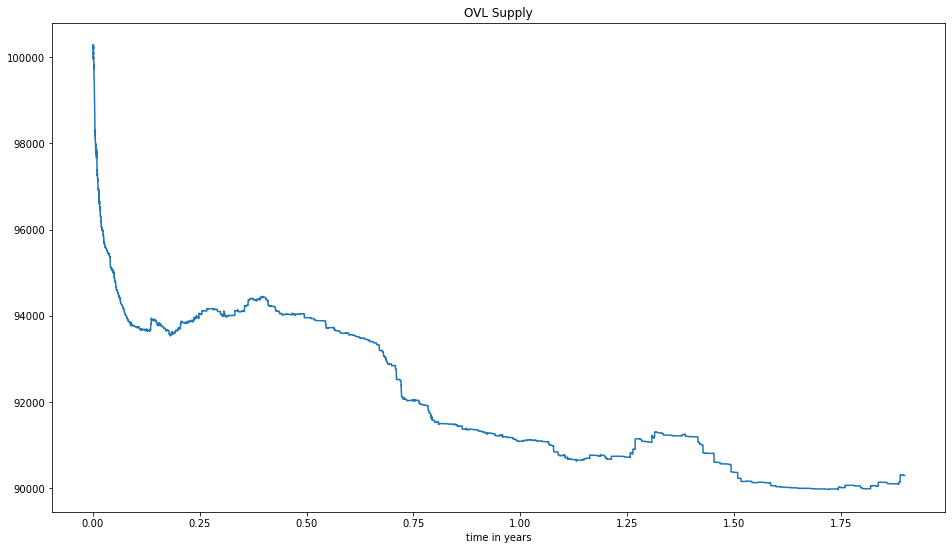

In [59]:
plot_supply(model_vars_df=model_vars_df, 
            plot_time_scale=plot_time_scale, 
            time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
            time_resolution=time_resolution, 
            data_interval=data_collection_options.data_collection_interval)

### Liquidity

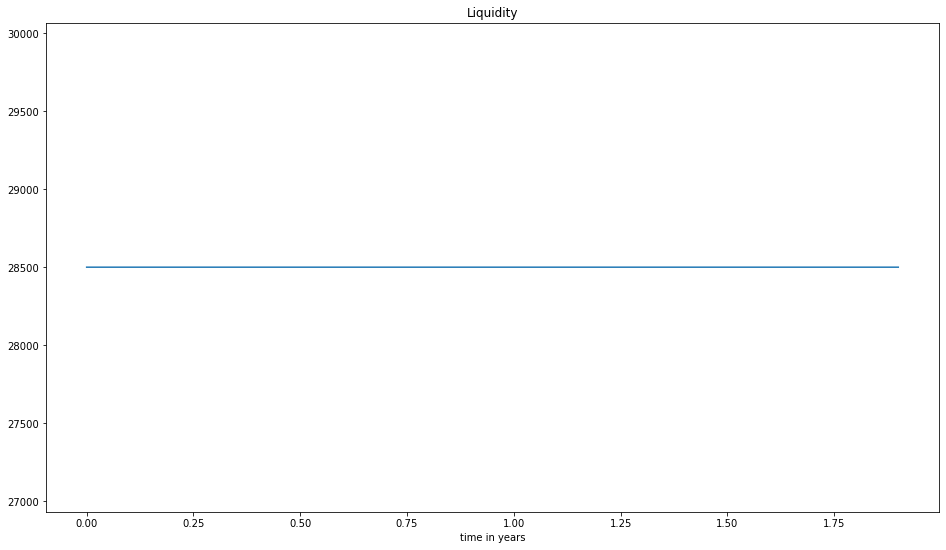

In [60]:
plot_liquidity(model_vars_df=model_vars_df,  
               plot_time_scale=plot_time_scale, 
               time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
               time_resolution=time_resolution, 
               data_interval=data_collection_options.data_collection_interval)

### Treasury

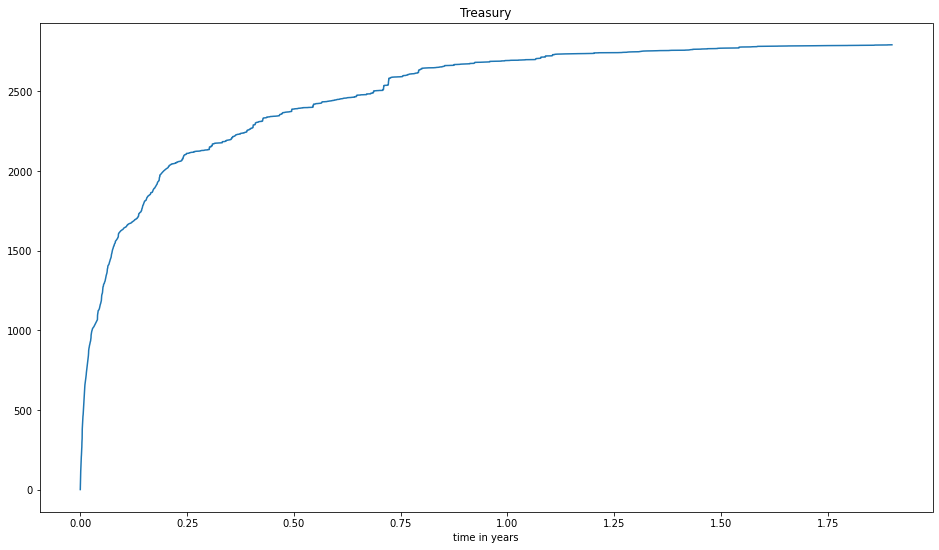

In [61]:
plot_treasury(model_vars_df=model_vars_df, 
              plot_time_scale=plot_time_scale, 
              time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
              time_resolution=time_resolution, 
              data_interval=data_collection_options.data_collection_interval)

### Price Deviations

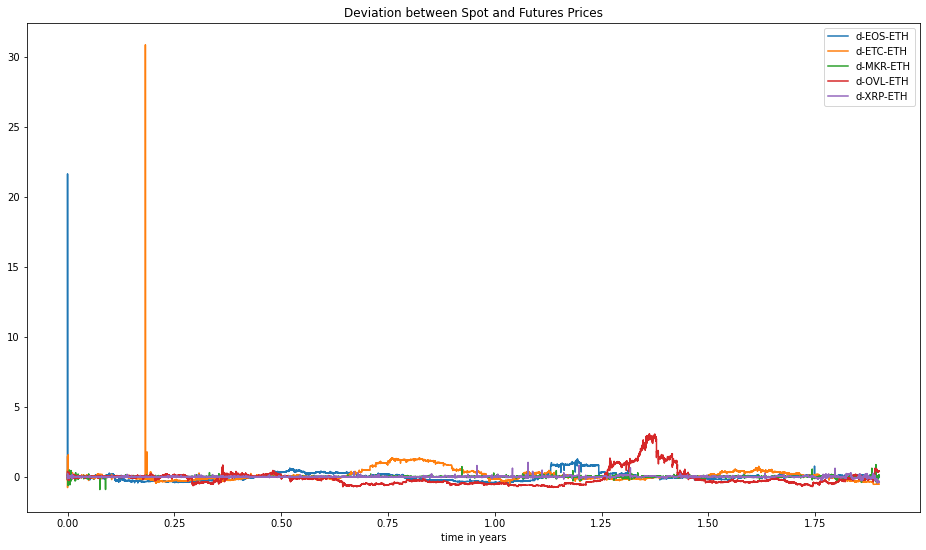

In [62]:
plot_price_deviations(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

### Open Positions

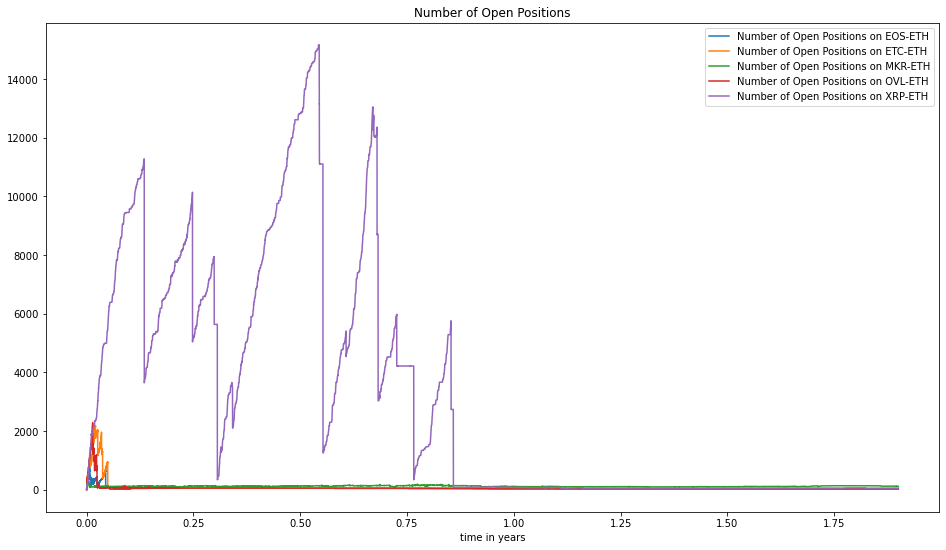

In [63]:
plot_open_positions(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

### Skew

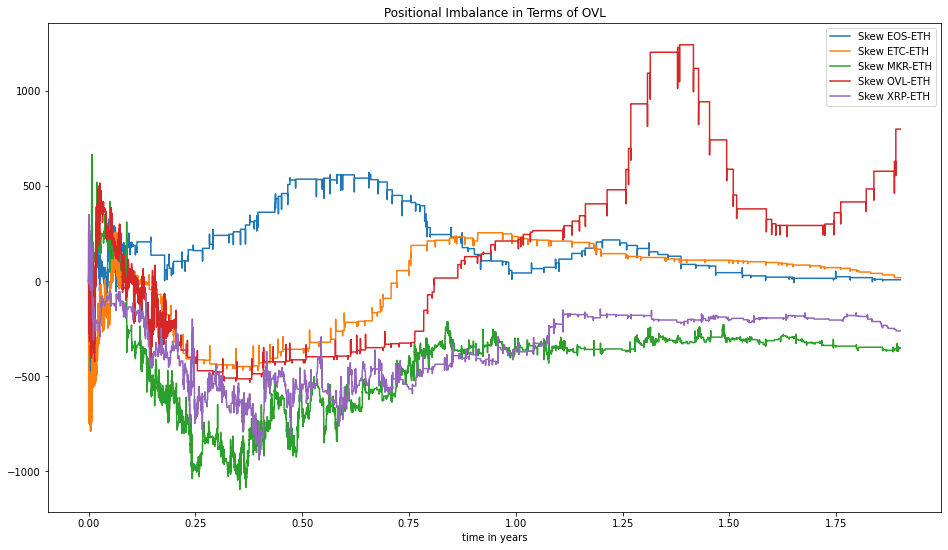

In [64]:
plot_skews(
    model_vars_df=model_vars_df, 
#     tickers=tickers_with_ovl[1:], 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

#### Correlation between Skew and Futures Price

In [65]:
for i, ticker in enumerate(tickers_with_ovl):
    if i > 0:
        break
    skew = model_vars_df.loc[:, skew_label(ticker)].values
    futures_price = model_vars_df.loc[:, futures_price_label(ticker)].values
    spot_price = model_vars_df.loc[:, spot_price_label(ticker)].values
    print(np.corrcoef(skew, futures_price))
    print(np.corrcoef(skew, spot_price))

[[1.         0.72434824]
 [0.72434824 1.        ]]
[[1.         0.45917163]
 [0.45917163 1.        ]]


### Cumulative Returns

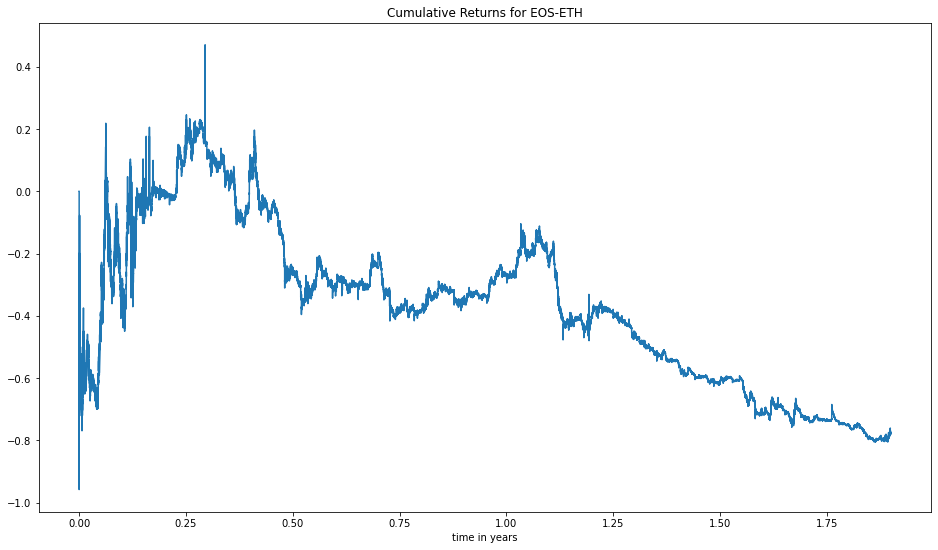

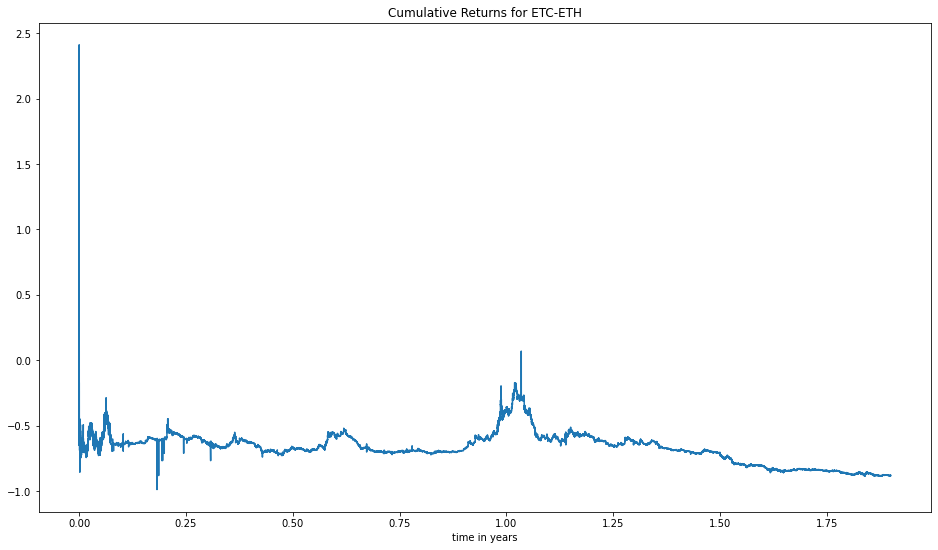

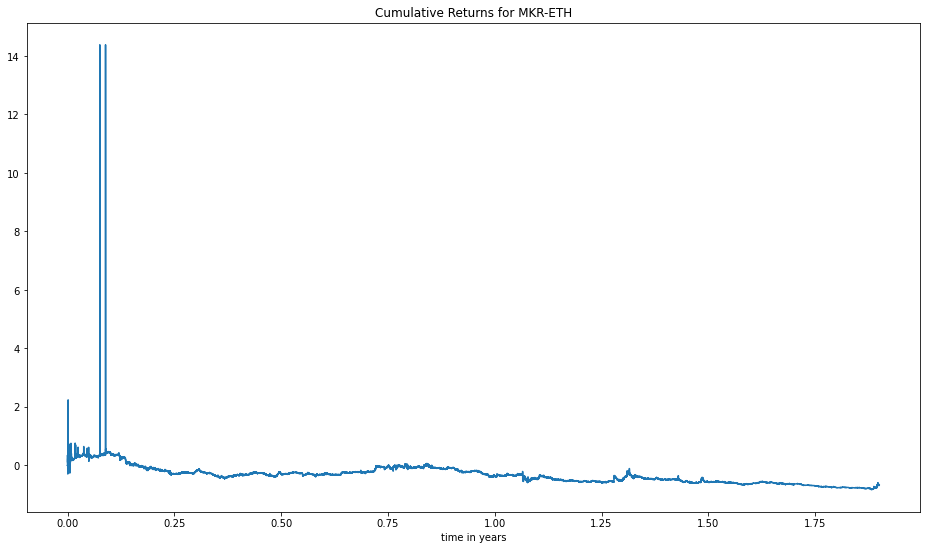

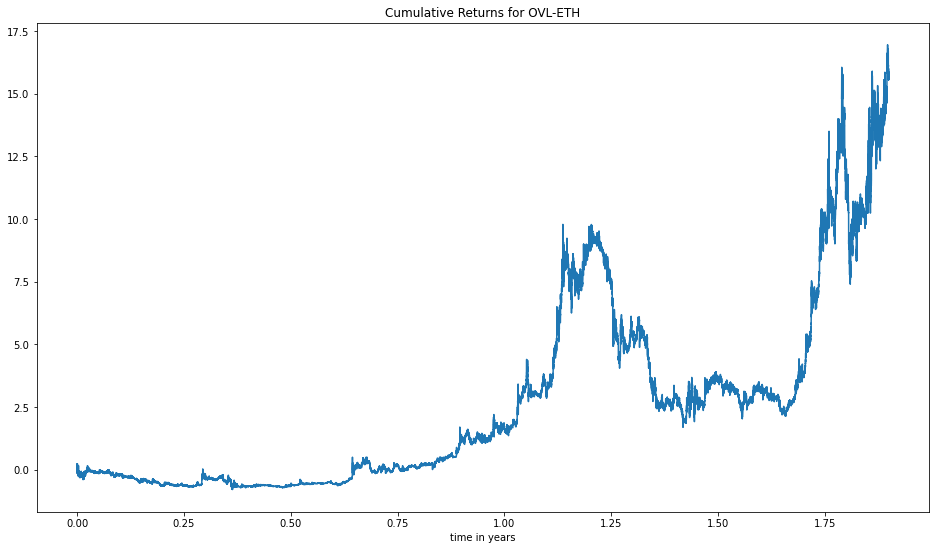

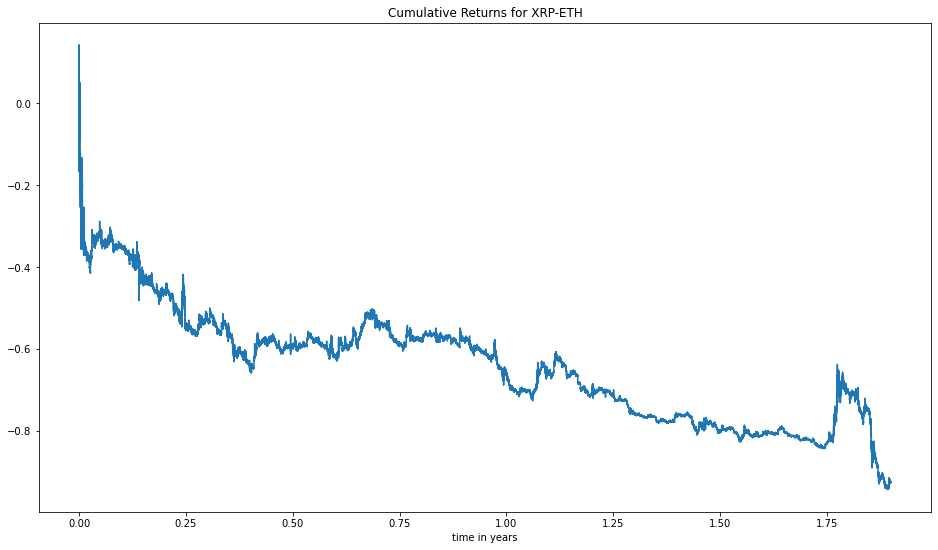

In [66]:
for i, ticker in enumerate(tickers_with_ovl):
    spot_prices_for_ticker = model_vars_df.loc[:, spot_price_label(ticker)].values
    cumulative_return_for_ticker = spot_prices_for_ticker / spot_prices_for_ticker[0] - 1.0
    
    plot_single_variable_over_time_from_numpy_array(
        array=cumulative_return_for_ticker, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        data_interval=data_collection_options.data_collection_interval)
    
    plt.title(f'Cumulative Returns for {ticker}')

### Spot vs. Futures Prices

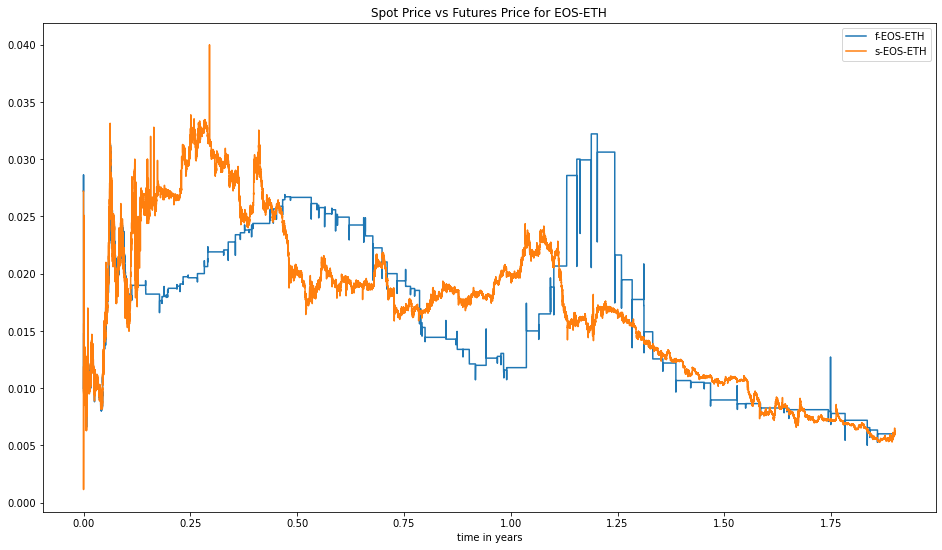

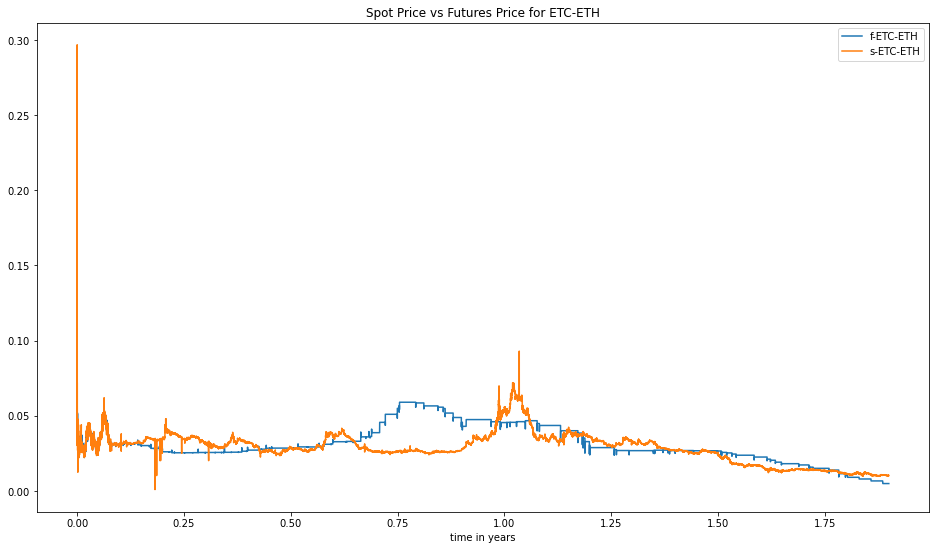

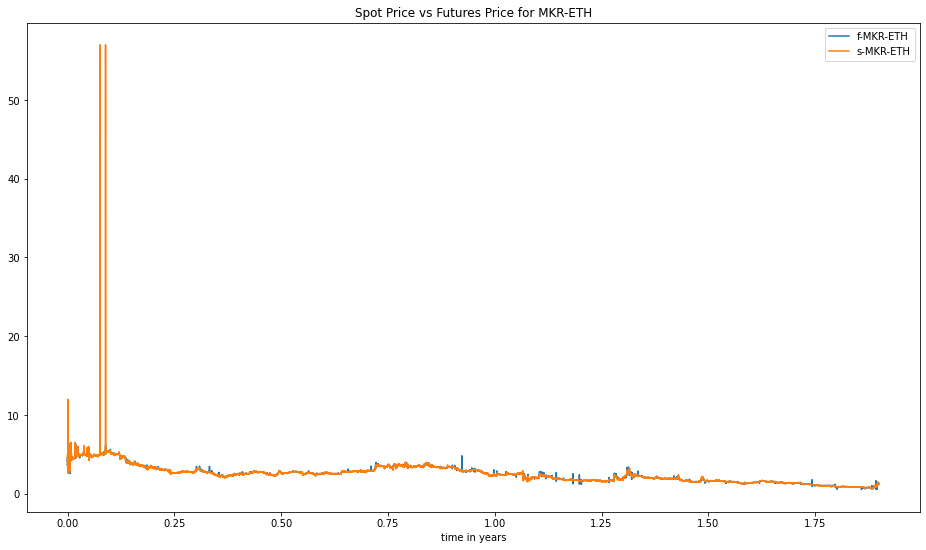

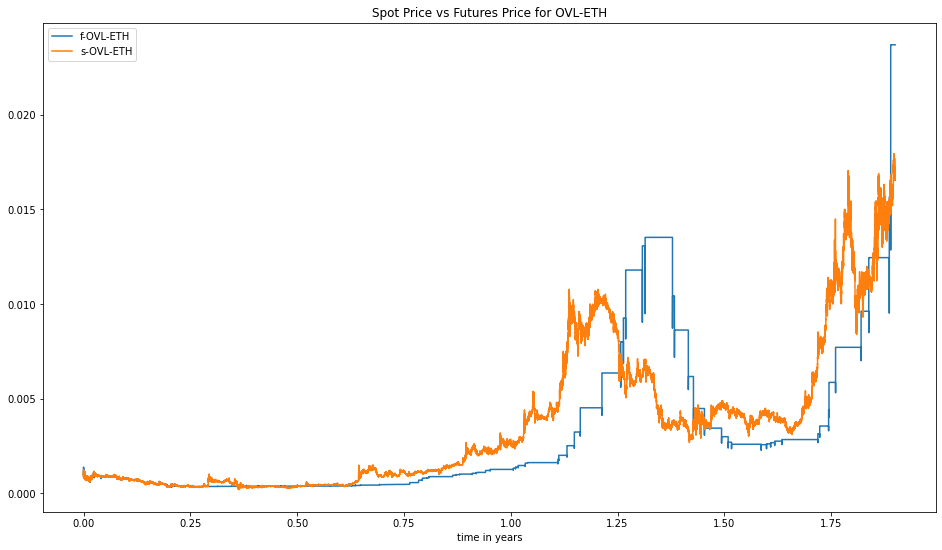

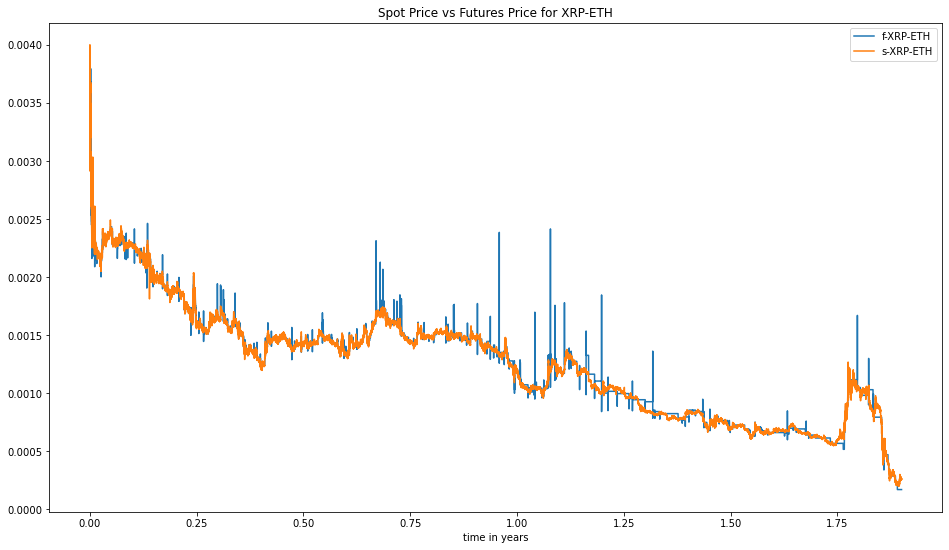

In [67]:
for i, ticker in enumerate(tickers_with_ovl):
    plot_spot_vs_futures_price(
        model_vars_df=model_vars_df, 
        ticker=ticker, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        data_interval=data_collection_options.data_collection_interval)

In [68]:
# model_vars_df.columns

In [69]:
# tickers_with_ovl[0]

In [70]:
# def plot_cumulative_spot_returns(
#         model_vars_df: pd.DataFrame,
#         ticker: str,
#         plot_time_scale: TimeScale,
#         time_resolution: TimeResolution,
#         time_interval_to_plot_in_seconds:
#         tp.Optional[tp.Tuple[tp.Optional[float], tp.Optional[float]]] = None,
#         figure_size: tp.Tuple[float, float] = DEFAULT_FIGURE_SIZE,
#         data_interval: int = 1,
#         # relative: bool = False
# ):
#     column_name_to_label_map = \
#         {spot_price_label(ticker): spot_price_label(ticker)}

#     plot_multiple_variables_over_time(
#         model_vars_df=model_vars_df,
#         column_name_to_label_map=column_name_to_label_map,
#         plot_time_scale=plot_time_scale,
#         time_resolution=time_resolution,
#         time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds,
#         figure_size=figure_size,
#         data_interval=data_interval)

#     plt.legend();
#     plt.title(f'Spot Price vs Futures Price for {ticker}')


In [71]:
# %lprun \
#     -f compute_gini \
#     -f compute_price_difference \
#     -f compute_futures_price \
#     -f compute_spot_price \
#     -f compute_supply \
#     -f compute_liquidity \
#     -f compute_treasury \
#     -f compute_wealth_for_agent_type \
#     -f compute_inventory_wealth_for_agent \
#     -f compute_inventory_wealth_for_agent_type \
#     -f compute_positional_imbalance_by_market \
#     -f DataCollector.collect \
#     -f MonetaryAgent.step \
#     -f MonetaryArbitrageur._unwind_positions \
#     -f MonetaryArbitrageur._unwind_next_position \
#     -f MonetaryArbitrageur.trade \
#     -f MonetaryArbitrageur.step \
#     -f MonetaryKeeper.step \
#     -f MonetaryKeeper.distribute_funding \
#     -f MonetaryLiquidator.scope_liquidations \
#     -f MonetaryLiquidator.step \
#     -f MonetarySniper._get_unwind_amount \
#     -f MonetarySniper._unwind_positions \
#     -f MonetarySniper._get_filled_price \
#     -f MonetarySniper._get_size \
#     -f MonetarySniper._get_effective_edge \
#     -f MonetarySniper.trade \
#     -f MonetaryFMarket.build \
#     -f MonetaryFMarket.unwind \
#     -f MonetaryFMarket._swap \
#     -f MonetaryFMarket.slippage \
#     -f MonetaryFMarket.fund \
#     -f MonetaryFMarket.funding \
#     -f MonetaryFMarket.liquidatable \
#     -f MonetaryFMarket.liquidate \
#     -f MonetaryModel.step \
#     run_model(number_of_steps_to_simulate)

In [72]:
# plt.close('all')